# 🌙 CL837 Sleep Data Analysis

Complete notebook for:
1. Connect to CL837 device via Bluetooth
2. UTC time synchronization
3. Download sleep data
4. Export to CSV
5. Visualize charts by night

**Requirements:** CL837 device powered on and nearby

In [1]:
# Imports
import asyncio
import time
import csv
from datetime import datetime, timezone, timedelta
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bleak import BleakClient, BleakScanner
import ast

# To run asyncio in Jupyter
import nest_asyncio
nest_asyncio.apply()

print("✅ Imports complete")

✅ Imports complete


## 📡 BLE Configuration

Chileaf protocol constants for Bluetooth Low Energy communication.

In [2]:
# Load from existing CSV or download from device if not found
import csv
import ast
import glob
from pathlib import Path
import os

# Auto-detect working directory (works on Mac, Windows, Linux)
# Use the directory where this notebook is located
SLEEP_DIR = Path(__file__).parent if '__file__' in dir() else Path.cwd()

# If we're not in the sleep folder, try to find it
if not (SLEEP_DIR / "sleep_data_*.csv").parent.exists():
    # Check if we're in the parent folder
    if (SLEEP_DIR / "sleep").exists():
        SLEEP_DIR = SLEEP_DIR / "sleep"
    # Or if sleep_data files exist in current dir
    elif glob.glob(str(SLEEP_DIR / "sleep_data_*.csv")):
        pass  # Already in correct dir
        
os.chdir(SLEEP_DIR)
print(f"📁 Working directory: {os.getcwd()}")

def load_from_csv(csv_file):
    """Load records from CSV file"""
    records = []
    with open(csv_file, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            records.append({
                'utc': int(row['utc_timestamp']),
                'count': int(row['interval_count']),
                'activity_indices': ast.literal_eval(row['activity_indices'])
            })
    return records


def save_to_csv(records, filename=None):
    """Save ALL records to CSV file (raw data, no filtering)"""
    if filename is None:
        filename = f"sleep_data_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    
    if not records:
        print("⚠️  No records to save!")
        return None
    
    with open(filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=[
            'record_number', 'utc_timestamp', 'datetime_utc', 'duration_minutes',
            'interval_count', 'deep_sleep_min', 'light_sleep_min', 'awake_min', 'activity_indices'
        ])
        writer.writeheader()
        
        for i, rec in enumerate(records, 1):
            dt = datetime.fromtimestamp(rec['utc'], tz=timezone.utc)
            deep, light, awake = 0, 0, 0
            zeros = 0
            for act in rec['activity_indices']:
                if act == 0:
                    zeros += 1
                else:
                    if zeros >= 3:
                        deep += zeros
                    elif zeros > 0:
                        light += zeros
                    zeros = 0
                    if act > 20:
                        awake += 1
                    else:
                        light += 1
            if zeros >= 3:
                deep += zeros
            elif zeros > 0:
                light += zeros
            
            writer.writerow({
                'record_number': i,
                'utc_timestamp': rec['utc'],
                'datetime_utc': dt.strftime('%Y-%m-%d %H:%M:%S'),
                'duration_minutes': rec['count'] * 5,
                'interval_count': rec['count'],
                'deep_sleep_min': deep * 5,
                'light_sleep_min': light * 5,
                'awake_min': awake * 5,
                'activity_indices': str(rec['activity_indices'])
            })
    
    print(f"💾 Saved {len(records)} records (raw data)")
    return filename


# Find the most recent sleep data CSV
csv_files = sorted(glob.glob("sleep_data_*.csv"), reverse=True)

all_records = []

if csv_files:
    csv_file = csv_files[0]
    print(f"📂 Found {len(csv_files)} CSV files")
    print(f"✅ Using most recent: {csv_file}")
    all_records = load_from_csv(csv_file)
    print(f"📊 Loaded {len(all_records)} records")
else:
    print("⚠️ No CSV file found!")
    print("👉 Run the BLE download cell to get data from device")

📁 Working directory: /Users/rtspla/VS_code/python_bt/python_bt/sleep
📂 Found 3 CSV files
✅ Using most recent: sleep_data_20251215_190951.csv
📊 Loaded 46 records


In [3]:
# Chileaf Protocol Constants
CHILEAF_SERVICE_UUID = "aae28f00-71b5-42a1-8c3c-f9cf6ac969d0"
CHILEAF_TX_UUID = "aae28f01-71b5-42a1-8c3c-f9cf6ac969d0"  # Notifications
CHILEAF_RX_UUID = "aae28f02-71b5-42a1-8c3c-f9cf6ac969d0"  # Write

CHILEAF_HEADER = 0xFF
CMD_SET_UTC = 0x08
CMD_GET_SLEEP = 0x05

# Validation
MIN_VALID_TIMESTAMP = 1577836800  # 2020-01-01

# Storage
all_records = []
data_complete = False
utc_confirmed = False

def calculate_checksum(data):
    """Calculate Chileaf checksum: ((0 - sum) & 0xFF) ^ 0x3A"""
    checksum = sum(data) & 0xFF
    checksum = (0 - checksum) & 0xFF
    checksum = checksum ^ 0x3A
    return checksum

print("✅ BLE configuration ready")

✅ BLE configuration ready


## 🔗 Connect and Download Data

Run this cell to:
1. Scan for CL837 device
2. Connect
3. Sync UTC time
4. Download all sleep data

In [4]:
def notification_handler(sender, data):
    """Handle BLE notifications from device"""
    global all_records, data_complete, utc_confirmed, last_packet_time
    
    if len(data) < 3 or data[0] != CHILEAF_HEADER:
        return
    
    command = data[2]
    
    # UTC sync confirmation
    if command == CMD_SET_UTC:
        utc_confirmed = True
    
    # Sleep data response
    elif command == CMD_GET_SLEEP and len(data) > 3:
        subcommand = data[3]
        last_packet_time = time.time()  # Track last packet received
        
        if subcommand == 0x03:  # Sleep data packet
            payload_end = data[1]
            idx = 4
            
            while idx < payload_end - 1:
                count = data[idx]
                idx += 1
                
                if idx + 4 > len(data):
                    break
                
                # Read UTC timestamp (4 bytes, big-endian)
                utc = (data[idx] << 24) | (data[idx+1] << 16) | (data[idx+2] << 8) | data[idx+3]
                idx += 4
                
                # Read activity indices
                activity_indices = []
                for i in range(count):
                    if idx < len(data) - 1:
                        activity_indices.append(data[idx])
                        idx += 1
                
                all_records.append({
                    'utc': utc,
                    'count': count,
                    'activity_indices': activity_indices
                })
        
        elif subcommand == 0xFF:  # End of data marker
            data_complete = True


async def download_sleep_data():
    """Connect to device and download sleep data"""
    global all_records, data_complete, utc_confirmed, last_packet_time
    
    # Reset
    all_records = []
    data_complete = False
    utc_confirmed = False
    last_packet_time = 0
    
    print("🔍 Scanning for CL837 devices...")
    devices = await BleakScanner.discover(timeout=8.0)
    cl837_devices = [d for d in devices if d.name and ("CL837" in d.name or "CL831" in d.name)]
    
    if not cl837_devices:
        print("❌ No CL837 devices found")
        return False
    
    device = cl837_devices[0]
    print(f"📱 Found: {device.name}")
    
    async with BleakClient(device, timeout=15.0) as client:
        print("✅ Connected")
        
        # Find characteristics
        tx_char = None
        rx_char = None
        for service in client.services:
            if service.uuid.lower() == CHILEAF_SERVICE_UUID.lower():
                for char in service.characteristics:
                    if char.uuid.lower() == CHILEAF_TX_UUID.lower():
                        tx_char = char
                    elif char.uuid.lower() == CHILEAF_RX_UUID.lower():
                        rx_char = char
        
        if not tx_char or not rx_char:
            print("❌ Chileaf characteristics not found")
            return False
        
        # Start notifications
        await client.start_notify(tx_char, notification_handler)
        await asyncio.sleep(0.3)
        
        # Sync UTC time
        print("\n⏰ Syncing UTC time...")
        utc_timestamp = int(time.time())
        utc_bytes = [
            (utc_timestamp >> 24) & 0xFF,
            (utc_timestamp >> 16) & 0xFF,
            (utc_timestamp >> 8) & 0xFF,
            utc_timestamp & 0xFF
        ]
        frame = [CHILEAF_HEADER, 0x08, CMD_SET_UTC] + utc_bytes
        frame.append(calculate_checksum(frame))
        await client.write_gatt_char(rx_char, bytes(frame))
        await asyncio.sleep(1.0)
        print(f"   UTC: {datetime.fromtimestamp(utc_timestamp, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')}")
        print("✅ UTC sync sent")
        
        # Request sleep data
        print("\n💤 Requesting sleep data...")
        frame = [CHILEAF_HEADER, 0x05, CMD_GET_SLEEP, 0x02]
        frame.append(calculate_checksum(frame))
        await client.write_gatt_char(rx_char, bytes(frame))
        
        # Wait for data - improved logic with longer timeouts
        print("⏳ Waiting for data (this may take up to 60 seconds)...")
        last_packet_time = time.time()
        timeout = 60           # Total timeout
        idle_timeout = 8       # Stop if no packets for 8 seconds (increased!)
        min_wait_after_data = 5  # Wait at least 5s after last data before giving up
        start = time.time()
        prev_count = 0
        last_progress_time = time.time()
        
        while (time.time() - start) < timeout:
            await asyncio.sleep(0.2)
            
            # Check if we got end marker
            if data_complete:
                print("   📦 End marker received - download complete!")
                break
            
            # Progress indicator and reset idle timer when new data arrives
            if len(all_records) > prev_count:
                print(f"   📥 {len(all_records)} records...")
                prev_count = len(all_records)
                last_packet_time = time.time()  # Reset idle timer
                last_progress_time = time.time()
            
            # Check for idle timeout (no new packets for a while)
            time_since_last = time.time() - last_packet_time
            if time_since_last > idle_timeout and len(all_records) > 0:
                # Only stop if we've received at least some data and waited long enough
                if time_since_last > min_wait_after_data:
                    print(f"   ⏱️ No new data for {time_since_last:.1f}s, finishing...")
                    break
        
        await client.stop_notify(tx_char)
    
    print(f"\n✅ Downloaded {len(all_records)} raw records")
    return True

# Run the download
success = asyncio.run(download_sleep_data())

# Auto-save to CSV if download successful
if success and all_records:
    csv_file = save_to_csv(all_records)
    print(f"💾 Auto-saved to: {csv_file}")

🔍 Scanning for CL837 devices...
📱 Found: CL837-0758807
✅ Connected

⏰ Syncing UTC time...
   UTC: 2025-12-15 18:15:19
✅ UTC sync sent

💤 Requesting sleep data...
⏳ Waiting for data (this may take up to 60 seconds)...
   📦 End marker received - download complete!

✅ Downloaded 46 raw records
💾 Saved 46 records (raw data)
💾 Auto-saved to: sleep_data_20251215_191520.csv


## 🔍 Validation and Sleep Stage Analysis

Filter valid records and classify sleep stages using the Chileaf SDK algorithm:
- **Deep Sleep**: 3+ consecutive zeros in activity index
- **Light Sleep**: activity 1-20 or < 3 consecutive zeros
- **Awake**: activity > 20

In [5]:
def analyze_sleep_stages(activity_indices):
    """
    Analyze sleep stages using Chileaf SDK algorithm.
    Each interval = 5 minutes
    """
    deep, light, awake = 0, 0, 0
    consecutive_zeros = 0
    
    for action in activity_indices:
        if action == 0:
            consecutive_zeros += 1
        else:
            # Process accumulated zeros
            if consecutive_zeros >= 3:
                deep += consecutive_zeros
            elif consecutive_zeros > 0:
                light += consecutive_zeros
            consecutive_zeros = 0
            
            # Process current value
            if action > 20:
                awake += 1
            else:  # 1-20
                light += 1
    
    # Process remaining zeros
    if consecutive_zeros >= 3:
        deep += consecutive_zeros
    elif consecutive_zeros > 0:
        light += consecutive_zeros
    
    return deep * 5, light * 5, awake * 5  # Convert to minutes


# Validate and process records
current_time = int(time.time())
valid_records = []

for rec in all_records:
    utc = rec['utc']
    count = rec['count']
    
    # Validate timestamp
    if utc >= MIN_VALID_TIMESTAMP and utc <= current_time and count > 0:
        deep, light, awake = analyze_sleep_stages(rec['activity_indices'])
        
        valid_records.append({
            'utc': utc,
            'datetime': datetime.fromtimestamp(utc, tz=timezone.utc),
            'duration_min': count * 5,
            'deep_min': deep,
            'light_min': light,
            'awake_min': awake,
            'activity_indices': rec['activity_indices']
        })

# Sort by timestamp
valid_records.sort(key=lambda x: x['utc'])

print(f"📊 Total raw records: {len(all_records)}")
print(f"✅ Valid records: {len(valid_records)}")
print(f"❌ Filtered records: {len(all_records) - len(valid_records)}")

if valid_records:
    print(f"\n📅 Range: {valid_records[0]['datetime'].strftime('%Y-%m-%d')} → {valid_records[-1]['datetime'].strftime('%Y-%m-%d')}")

📊 Total raw records: 46
✅ Valid records: 46
❌ Filtered records: 0

📅 Range: 2025-12-13 → 2025-12-15


In [6]:
# Debug: Show last 20 raw records with timestamps
print(f"Total raw records: {len(all_records)}")
print("\nLast 20 raw records:")
for i, rec in enumerate(all_records[-20:], len(all_records)-19):
    utc = rec['utc']
    try:
        dt = datetime.fromtimestamp(utc, tz=timezone.utc).strftime('%Y-%m-%d %H:%M')
    except:
        dt = "INVALID"
    valid = "✅" if utc >= MIN_VALID_TIMESTAMP else "❌"
    print(f"  {i}: UTC={utc} → {dt} {valid} count={rec['count']}")

Total raw records: 46

Last 20 raw records:
  27: UTC=1765745449 → 2025-12-14 20:50 ✅ count=12
  28: UTC=1765749049 → 2025-12-14 21:50 ✅ count=12
  29: UTC=1765752649 → 2025-12-14 22:50 ✅ count=12
  30: UTC=1765756249 → 2025-12-14 23:50 ✅ count=12
  31: UTC=1765759849 → 2025-12-15 00:50 ✅ count=12
  32: UTC=1765763449 → 2025-12-15 01:50 ✅ count=12
  33: UTC=1765767049 → 2025-12-15 02:50 ✅ count=12
  34: UTC=1765770649 → 2025-12-15 03:50 ✅ count=2
  35: UTC=1765769675 → 2025-12-15 03:34 ✅ count=8
  36: UTC=1765773766 → 2025-12-15 04:42 ✅ count=12
  37: UTC=1765777366 → 2025-12-15 05:42 ✅ count=12
  38: UTC=1765780966 → 2025-12-15 06:42 ✅ count=2
  39: UTC=1765779165 → 2025-12-15 06:12 ✅ count=8
  40: UTC=1765787001 → 2025-12-15 08:23 ✅ count=4
  41: UTC=1765792769 → 2025-12-15 09:59 ✅ count=6
  42: UTC=1765797215 → 2025-12-15 11:13 ✅ count=7
  43: UTC=1765803704 → 2025-12-15 13:01 ✅ count=7
  44: UTC=1765807686 → 2025-12-15 14:08 ✅ count=12
  45: UTC=1765811286 → 2025-12-15 15:08 ✅ coun

## 💾 Export CSV

Save validated data to a timestamped CSV file.

In [7]:
# Export to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_filename = f"sleep_data_{timestamp}.csv"

if valid_records:
    with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=[
            'record_number', 'utc_timestamp', 'datetime_utc', 'duration_minutes',
            'interval_count', 'deep_sleep_min', 'light_sleep_min', 'awake_min', 'activity_indices'
        ])
        writer.writeheader()
        
        for i, rec in enumerate(valid_records, 1):
            writer.writerow({
                'record_number': i,
                'utc_timestamp': rec['utc'],
                'datetime_utc': rec['datetime'].strftime('%Y-%m-%d %H:%M:%S'),
                'duration_minutes': rec['duration_min'],
                'interval_count': rec['duration_min'] // 5,
                'deep_sleep_min': rec['deep_min'],
                'light_sleep_min': rec['light_min'],
                'awake_min': rec['awake_min'],
                'activity_indices': str(rec['activity_indices'])
            })
    
    print(f"✅ Exported to: {csv_filename}")
else:
    print("⚠️ No valid records to export")

✅ Exported to: sleep_data_20251215_191521.csv


## 🌙 Group by Night

Group records into sleep sessions (nights):
- Gap > 3 hours = new session
- Calculate totals for each night

In [8]:
# Local timezone offset (Italy = UTC+1, or UTC+2 during DST)
LOCAL_TZ_OFFSET = 1  # hours from UTC

# ========== 🛏️ BEDTIME HINTS - PERSONALIZZA QUI! ==========
# Imposta i tuoi orari tipici per evitare falsi positivi (es. divano dopo cena)
#
# TYPICAL_BEDTIME_START: Ora più presto a cui vai REALMENTE a dormire
#                        (non quando ti siedi sul divano!)
# TYPICAL_BEDTIME_END:   Ora più tarda a cui vai a dormire
# TYPICAL_WAKE_START:    Ora più presto a cui ti svegli
# TYPICAL_WAKE_END:      Ora più tardi a cui ti svegli

TYPICAL_BEDTIME_START = 21.5  # 21:30 - di solito non vai a letto prima
TYPICAL_BEDTIME_END = 24.0    # 00:00 - di solito non vai a letto dopo
TYPICAL_WAKE_START = 6.0      # 06:00 - di solito non ti svegli prima
TYPICAL_WAKE_END = 9.0        # 09:00 - di solito non ti svegli dopo

# Minima durata per considerare un periodo come "sonno vero" vs "divano"
MIN_REAL_SLEEP_DURATION = 60  # minuti - meno di 1h è probabilmente divano/riposo

# ========== PLAUSIBLE SLEEP WINDOWS (window più ampia, validazione più stretta) ==========
# Questa è la finestra AMPIA - accetta tutto, poi filtra con bedtime hints
NIGHT_WINDOW_START = 19   # 19:00 - finestra ampia per catturare tutto
NIGHT_WINDOW_END = 11     # 11:00 next day
NAP_WINDOW_START = 12     # 12:00
NAP_WINDOW_END = 17       # 17:00

# Session classification thresholds
MIN_NIGHT_DURATION = 180  # 3 hours minimum for "real" night
NIGHT_START_HOUR = 20     # 20:00 - night starts
NIGHT_END_HOUR = 10       # 10:00 - night ends
MIN_DEEP_PERCENT = 15     # minimum deep sleep % for quality

# ========== HR VALIDATION (usa HR per confermare sonno reale) ==========
# Durante il sonno la frequenza cardiaca tende a essere più bassa e stabile
HR_SLEEP_THRESHOLD = 70   # HR tipica durante sonno (sotto questo valore = più probabile sonno)
HR_AWAKE_THRESHOLD = 85   # HR tipica da svegli (sopra = probabilmente non sta dormendo)

def format_duration(minutes):
    """Format duration in hours and minutes"""
    hours = minutes // 60
    mins = minutes % 60
    if hours > 0:
        return f"{hours}h {mins}m"
    return f"{mins}m"


def get_night_label(dt):
    """Generate label for the night (using local time)"""
    local_dt = dt + timedelta(hours=LOCAL_TZ_OFFSET)
    night_date = (local_dt - timedelta(hours=18)).date() if local_dt.hour < 18 else local_dt.date()
    next_day = night_date + timedelta(days=1)
    return f"{night_date.strftime('%d')}→{next_day.strftime('%d %b')}"


def to_local(dt):
    """Convert UTC datetime to local time"""
    return dt + timedelta(hours=LOCAL_TZ_OFFSET)


def hour_to_float(dt):
    """Convert datetime hour:minute to float (e.g., 21:30 → 21.5)"""
    return dt.hour + dt.minute / 60


def is_in_plausible_sleep_window(dt):
    """
    Check if a datetime falls within plausible sleep windows:
    - Night: 19:00 - 11:00 (next day) - wide window
    - Nap:   12:00 - 17:00
    Returns: (is_valid, window_type)
    """
    local_dt = to_local(dt)
    hour = local_dt.hour
    
    # Night window: 19:00-23:59 OR 00:00-11:00
    if hour >= NIGHT_WINDOW_START or hour < NIGHT_WINDOW_END:
        return True, "night"
    
    # Nap window: 12:00-17:00
    if NAP_WINDOW_START <= hour < NAP_WINDOW_END:
        return True, "nap"
    
    return False, None


def is_likely_real_sleep(bedtime, wake_time, total_min, deep_min, avg_hr=None):
    """
    Determina se una sessione è SONNO REALE o falso positivo (divano/riposo).
    
    Usa:
    1. Bedtime hints (orario tipico)
    2. Durata minima
    3. Percentuale deep sleep
    4. HR media (se disponibile)
    
    Returns: (is_real_sleep, confidence, reason)
    """
    local_bed = to_local(bedtime)
    local_wake = to_local(wake_time)
    bed_hour = hour_to_float(local_bed)
    wake_hour = hour_to_float(local_wake)
    
    # Normalizza bed_hour per gestire la mezzanotte (0-4 → 24-28)
    if bed_hour < 12:
        bed_hour_norm = bed_hour + 24
    else:
        bed_hour_norm = bed_hour
    
    confidence = 0
    reasons = []
    
    # 1. CHECK BEDTIME HINT
    if TYPICAL_BEDTIME_START <= bed_hour_norm <= TYPICAL_BEDTIME_END + 24:
        confidence += 30
        reasons.append(f"✅ Bedtime in range tipico ({local_bed.strftime('%H:%M')})")
    elif bed_hour_norm < TYPICAL_BEDTIME_START:
        # Troppo presto - probabilmente divano!
        confidence -= 20
        reasons.append(f"⚠️ Bedtime troppo presto ({local_bed.strftime('%H:%M')} < {int(TYPICAL_BEDTIME_START)}:{int((TYPICAL_BEDTIME_START%1)*60):02d})")
    
    # 2. CHECK WAKE TIME
    if TYPICAL_WAKE_START <= wake_hour <= TYPICAL_WAKE_END:
        confidence += 20
        reasons.append(f"✅ Wake time in range tipico ({local_wake.strftime('%H:%M')})")
    
    # 3. CHECK DURATA
    if total_min >= MIN_NIGHT_DURATION:
        confidence += 25
        reasons.append(f"✅ Durata sufficiente ({format_duration(total_min)})")
    elif total_min >= MIN_REAL_SLEEP_DURATION:
        confidence += 10
        reasons.append(f"⚠️ Durata breve ({format_duration(total_min)})")
    else:
        confidence -= 15
        reasons.append(f"❌ Durata troppo breve ({format_duration(total_min)})")
    
    # 4. CHECK DEEP SLEEP %
    deep_pct = (deep_min / total_min * 100) if total_min > 0 else 0
    if deep_pct >= 15:
        confidence += 25
        reasons.append(f"✅ Deep sleep buono ({deep_pct:.0f}%)")
    elif deep_pct >= 8:
        confidence += 10
        reasons.append(f"⚠️ Deep sleep basso ({deep_pct:.0f}%)")
    else:
        confidence -= 10
        reasons.append(f"❌ Deep sleep molto basso ({deep_pct:.0f}%)")
    
    # 5. CHECK HR (se disponibile)
    if avg_hr is not None and avg_hr > 0:
        if avg_hr <= HR_SLEEP_THRESHOLD:
            confidence += 20
            reasons.append(f"✅ HR bassa, tipica sonno ({avg_hr} bpm)")
        elif avg_hr >= HR_AWAKE_THRESHOLD:
            confidence -= 15
            reasons.append(f"⚠️ HR alta, forse sveglio ({avg_hr} bpm)")
        else:
            confidence += 5
            reasons.append(f"HR nella norma ({avg_hr} bpm)")
    
    # Decisione finale
    is_real = confidence >= 40
    
    return is_real, confidence, reasons


def classify_session(bedtime, wake_time, total_min, deep_min, avg_hr=None):
    """
    Classify sleep session type con validazione bedtime hints + HR:
    - 🌙 NIGHT: real overnight sleep
    - 😴 NAP: short daytime sleep
    - 🛋️ COUCH: probabilmente divano/riposo, non sonno reale
    - ❓ UNCERTAIN: non chiaro
    """
    is_real, confidence, reasons = is_likely_real_sleep(bedtime, wake_time, total_min, deep_min, avg_hr)
    
    local_bed = to_local(bedtime)
    bed_hour = local_bed.hour
    
    # Check if in nighttime window
    is_nighttime = (bed_hour >= 20 or bed_hour < 4)
    
    if is_real:
        if total_min >= MIN_NIGHT_DURATION and is_nighttime:
            return "🌙 NIGHT", f"Sonno reale (conf: {confidence}%)", reasons
        elif total_min >= 60:
            if 11 <= bed_hour <= 17:
                return "😴 NAP", f"Pisolino (conf: {confidence}%)", reasons
            else:
                return "🌙 NIGHT?", f"Notte breve (conf: {confidence}%)", reasons
        else:
            return "😴 NAP", f"Riposo breve (conf: {confidence}%)", reasons
    else:
        if bed_hour >= 18 and bed_hour < 22:
            return "🛋️ COUCH", f"Probabilmente divano (conf: {confidence}%)", reasons
        elif total_min < MIN_REAL_SLEEP_DURATION:
            return "🛋️ REST", f"Riposo/falso positivo (conf: {confidence}%)", reasons
        else:
            return "❓ UNCERTAIN", f"Non chiaro (conf: {confidence}%)", reasons


# ========== FILTER RECORDS BY PLAUSIBLE SLEEP WINDOWS ==========
print("🔍 Filtering records by plausible sleep windows...")
print(f"   🌙 Night window: {NIGHT_WINDOW_START}:00 → {NIGHT_WINDOW_END}:00")
print(f"   😴 Nap window:   {NAP_WINDOW_START}:00 → {NAP_WINDOW_END}:00")
print(f"\n🛏️  Bedtime hints:")
print(f"   Vai a letto tipicamente: {int(TYPICAL_BEDTIME_START)}:{int((TYPICAL_BEDTIME_START%1)*60):02d} - {int(TYPICAL_BEDTIME_END)}:{int((TYPICAL_BEDTIME_END%1)*60):02d}")
print(f"   Ti svegli tipicamente:   {int(TYPICAL_WAKE_START)}:{int((TYPICAL_WAKE_START%1)*60):02d} - {int(TYPICAL_WAKE_END)}:{int((TYPICAL_WAKE_END%1)*60):02d}")
print(f"   Durata minima sonno:     {MIN_REAL_SLEEP_DURATION} min\n")

filtered_records = []
rejected_records = []

for rec in valid_records:
    rec_time = rec['datetime']
    is_valid, window_type = is_in_plausible_sleep_window(rec_time)
    
    if is_valid:
        rec['window_type'] = window_type
        filtered_records.append(rec)
    else:
        rejected_records.append(rec)

print(f"📊 Original records: {len(valid_records)}")
print(f"✅ Plausible sleep:  {len(filtered_records)}")
print(f"❌ Rejected:         {len(rejected_records)}")

if rejected_records:
    print(f"\n⚠️ Rejected records (outside sleep windows):")
    for rec in rejected_records[:10]:  # Show first 10
        local_time = to_local(rec['datetime'])
        print(f"   {local_time.strftime('%Y-%m-%d %H:%M')} - {rec['duration_min']}min")
    if len(rejected_records) > 10:
        print(f"   ... and {len(rejected_records) - 10} more")


# Group into sessions (gap > 3 hours = new session)
# Using filtered_records now!
sessions = []
current_session = []

for rec in filtered_records:  # <-- CHANGED: use filtered_records
    if not current_session:
        current_session.append(rec)
    else:
        last_utc = current_session[-1]['utc']
        last_duration = current_session[-1]['duration_min'] * 60  # in seconds
        gap = rec['utc'] - (last_utc + last_duration)
        
        if gap > 3 * 3600:  # > 3 hours
            sessions.append(current_session)
            current_session = [rec]
        else:
            current_session.append(rec)

if current_session:
    sessions.append(current_session)

# Calculate stats for each session
nights_data = []

for session in sessions:
    deep = sum(r['deep_min'] for r in session)
    light = sum(r['light_min'] for r in session)
    awake = sum(r['awake_min'] for r in session)
    total = deep + light + awake
    
    if total == 0:
        continue
    
    bedtime = session[0]['datetime']
    wake_time = session[-1]['datetime'] + timedelta(minutes=session[-1]['duration_min'])
    efficiency = ((deep + light) / total * 100) if total > 0 else 0
    
    # Try to get HR data for this session (if available)
    avg_hr = None
    if 'hr_sessions' in dir() and hr_sessions:
        # Find HR data overlapping with this sleep session
        session_hrs = []
        for hr_utc, hr_list in hr_sessions.items():
            hr_time = datetime.fromtimestamp(hr_utc, tz=timezone.utc)
            if bedtime <= hr_time <= wake_time:
                # hr_list contains dicts with 'hr' key, extract the values
                for h in hr_list:
                    if isinstance(h, dict) and 'hr' in h:
                        session_hrs.append(h['hr'])
                    elif isinstance(h, (int, float)):
                        session_hrs.append(h)
        if session_hrs:
            avg_hr = sum(session_hrs) / len(session_hrs)
    
    # Classify the session with new logic
    session_type, session_note, reasons = classify_session(bedtime, wake_time, total, deep, avg_hr)
    
    nights_data.append({
        'label': get_night_label(bedtime),
        'bedtime': bedtime,
        'wake_time': wake_time,
        'deep': deep,
        'light': light,
        'awake': awake,
        'total': total,
        'efficiency': efficiency,
        'records': len(session),
        'type': session_type,
        'note': session_note,
        'reasons': reasons,
        'avg_hr': avg_hr
    })

print(f"\n{'='*120}")
print(f"🌙 Found {len(nights_data)} sleep sessions (times in local: UTC+{LOCAL_TZ_OFFSET})")
print("="*120)
print(f"{'Type':<14} {'Night':<15} {'Bedtime':<8} {'Wake':<8} {'Total':<10} {'Deep':<10} {'Light':<10} {'HR':<6} {'Note':<30}")
print("-"*120)

for night in nights_data:
    local_bed = to_local(night['bedtime'])
    local_wake = to_local(night['wake_time'])
    hr_str = f"{night['avg_hr']:.0f}" if night['avg_hr'] else "-"
    print(f"{night['type']:<14} {night['label']:<15} {local_bed.strftime('%H:%M'):<8} {local_wake.strftime('%H:%M'):<8} "
          f"{format_duration(night['total']):<10} {format_duration(night['deep']):<10} "
          f"{format_duration(night['light']):<10} {hr_str:<6} {night['note']:<30}")

print("="*120)

# Summary
real_nights = [n for n in nights_data if "NIGHT" in n['type'] and "?" not in n['type']]
naps = [n for n in nights_data if "NAP" in n['type']]
couch = [n for n in nights_data if "COUCH" in n['type'] or "REST" in n['type']]
uncertain = [n for n in nights_data if "UNCERTAIN" in n['type']]

print(f"\n📊 Summary:")
print(f"   🌙 Notti reali:    {len(real_nights)}")
print(f"   😴 Pisolini:       {len(naps)}")
print(f"   🛋️  Divano/Riposo: {len(couch)}")
print(f"   ❓ Incerti:        {len(uncertain)}")

# Show details for uncertain/couch sessions
if couch or uncertain:
    print(f"\n⚠️ Sessioni dubbie (possibili falsi positivi):")
    for n in couch + uncertain:
        local_bed = to_local(n['bedtime'])
        print(f"\n   {n['type']} {n['label']} @ {local_bed.strftime('%H:%M')}")
        for reason in n['reasons']:
            print(f"      {reason}")


🔍 Filtering records by plausible sleep windows...
   🌙 Night window: 19:00 → 11:00
   😴 Nap window:   12:00 → 17:00

🛏️  Bedtime hints:
   Vai a letto tipicamente: 21:30 - 24:00
   Ti svegli tipicamente:   6:00 - 9:00
   Durata minima sonno:     60 min

📊 Original records: 46
✅ Plausible sleep:  44
❌ Rejected:         2

⚠️ Rejected records (outside sleep windows):
   2025-12-14 18:15 - 25min
   2025-12-15 17:44 - 30min

🌙 Found 2 sleep sessions (times in local: UTC+1)
Type           Night           Bedtime  Wake     Total      Deep       Light      HR     Note                          
------------------------------------------------------------------------------------------------------------------------
❓ UNCERTAIN    12→13 Dec       14:25    16:41    1h 30m     0m         1h 30m     -      Non chiaro (conf: -20%)       
🛋️ COUCH       13→14 Dec       20:45    16:38    30h 45m    11h 55m    18h 25m    -      Probabilmente divano (conf: 30%)

📊 Summary:
   🌙 Notti reali:    0
   😴 Pis

## 📊 Donut Charts by Night

Visualize sleep stage distribution for each night with:
- Deep Sleep (dark blue)
- Light Sleep (light blue)
- Awake (orange)
- Total duration in center
- Bedtime and wake time

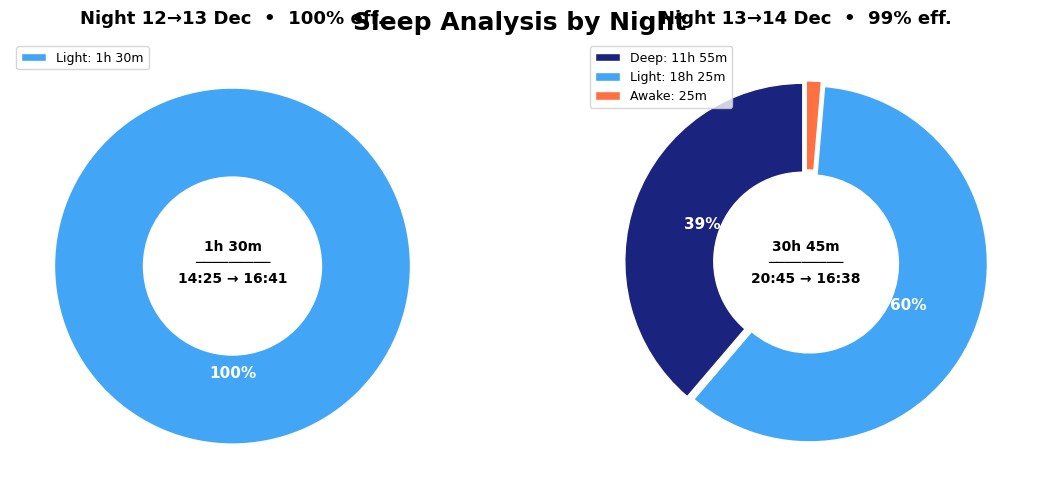


✅ Saved: night_donuts.png


In [9]:
# Clear any previous figures
plt.close('all')

if not nights_data:
    print("⚠️ No data to display")
else:
    # Determine grid layout
    n_nights = len(nights_data)
    cols = min(3, n_nights)
    rows = (n_nights + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    fig.suptitle('Sleep Analysis by Night', fontsize=18, fontweight='bold')
    
    # Flatten axes
    if n_nights == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    
    colors = ['#1a237e', '#42a5f5', '#ff7043']  # Deep, Light, Awake
    
    for idx, night in enumerate(nights_data):
        ax = axes[idx]
        
        # Data for donut chart
        sizes = [night['deep'], night['light'], night['awake']]
        labels_pie = ['Deep', 'Light', 'Awake']
        
        # Remove zero slices
        non_zero = [(s, l, c) for s, l, c in zip(sizes, labels_pie, colors) if s > 0]
        if non_zero:
            sizes, labels_pie, pie_colors = zip(*non_zero)
        else:
            continue
        
        # Donut chart
        wedges, texts, autotexts = ax.pie(
            sizes, 
            labels=None,
            autopct=lambda pct: f'{pct:.0f}%' if pct > 5 else '',
            colors=pie_colors,
            startangle=90,
            explode=[0.02] * len(sizes),
            wedgeprops=dict(width=0.5, edgecolor='white'),
            textprops={'fontsize': 11, 'fontweight': 'bold', 'color': 'white'}
        )
        
        # Convert to local time for display
        local_bed = to_local(night['bedtime'])
        local_wake = to_local(night['wake_time'])
        
        # Center text: total duration + times (local)
        center_text = (
            f"{format_duration(night['total'])}\n"
            f"─────────\n"
            f"{local_bed.strftime('%H:%M')} → {local_wake.strftime('%H:%M')}"
        )
        ax.text(0, 0, center_text, ha='center', va='center', fontsize=10, fontweight='bold')
        
        # Title with efficiency
        ax.set_title(f"Night {night['label']}  •  {night['efficiency']:.0f}% eff.", 
                     fontsize=13, fontweight='bold', pad=12)
        
        # Legend with durations only
        legend_labels = [f"{l}: {format_duration(s)}" for l, s in zip(labels_pie, sizes)]
        ax.legend(wedges, legend_labels, loc='upper left', fontsize=9)
    
    # Hide empty axes
    for idx in range(n_nights, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, hspace=0.3)
    plt.savefig('night_donuts.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✅ Saved: night_donuts.png")

## 📈 Sleep Duration Summary by Night

Comparative bar chart of all nights.

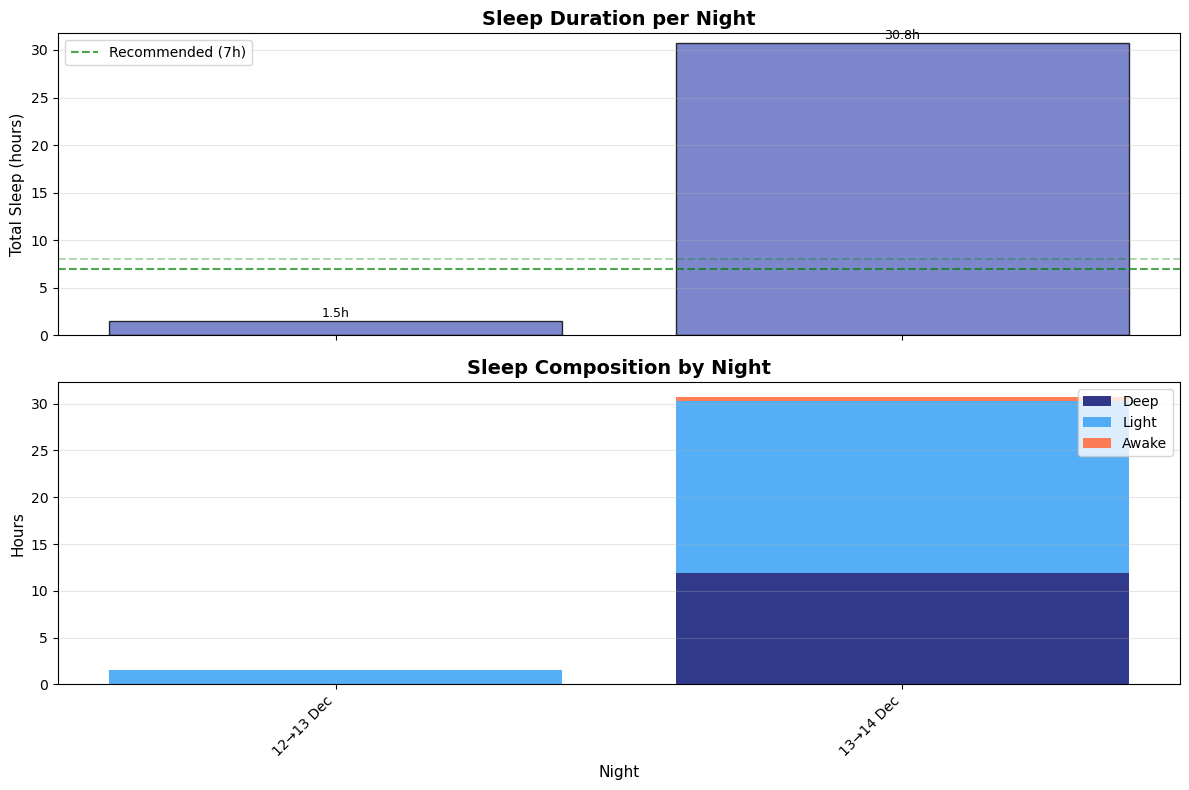


✅ Saved: daily_summary.png


In [10]:
if not nights_data:
    print("⚠️ No data to display")
else:
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    x_pos = range(len(nights_data))
    labels = [n['label'] for n in nights_data]
    
    # Chart 1: Total duration
    ax1 = axes[0]
    total_hours = [n['total'] / 60 for n in nights_data]
    bars = ax1.bar(x_pos, total_hours, color='#5c6bc0', alpha=0.8, edgecolor='black')
    ax1.axhline(y=7, color='green', linestyle='--', alpha=0.7, label='Recommended (7h)')
    ax1.axhline(y=8, color='green', linestyle='--', alpha=0.3)
    ax1.set_ylabel('Total Sleep (hours)', fontsize=11)
    ax1.set_title('Sleep Duration per Night', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim(0, max(total_hours) + 1)
    
    for bar, hours in zip(bars, total_hours):
        if hours > 0:
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                    f'{hours:.1f}h', ha='center', va='bottom', fontsize=9)
    
    # Chart 2: Composition
    ax2 = axes[1]
    deep_h = [n['deep'] / 60 for n in nights_data]
    light_h = [n['light'] / 60 for n in nights_data]
    awake_h = [n['awake'] / 60 for n in nights_data]
    
    ax2.bar(x_pos, deep_h, label='Deep', color='#1a237e', alpha=0.9)
    ax2.bar(x_pos, light_h, bottom=deep_h, label='Light', color='#42a5f5', alpha=0.9)
    ax2.bar(x_pos, awake_h, bottom=[d + l for d, l in zip(deep_h, light_h)], 
            label='Awake', color='#ff7043', alpha=0.9)
    
    ax2.set_xlabel('Night', fontsize=11)
    ax2.set_ylabel('Hours', fontsize=11)
    ax2.set_title('Sleep Composition by Night', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(axis='y', alpha=0.3)
    
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('daily_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✅ Saved: daily_summary.png")

## 📋 Last Night Details

Detailed information about the most recent sleep session.

In [11]:
if nights_data:
    last = nights_data[-1]
    
    # Convert to local time
    local_bedtime = to_local(last['bedtime'])
    local_wake = to_local(last['wake_time'])
    
    print("="*50)
    print(f"  LAST NIGHT: {last['label']}")
    print("="*50)
    print(f"")
    print(f"  Bedtime:     {local_bedtime.strftime('%H:%M')} (UTC+{LOCAL_TZ_OFFSET})")
    print(f"  Wake:        {local_wake.strftime('%H:%M')} (UTC+{LOCAL_TZ_OFFSET})")
    print(f"")
    print(f"  Total duration:  {format_duration(last['total'])}")
    print(f"  - Deep Sleep:    {format_duration(last['deep'])} ({last['deep']/last['total']*100:.0f}%)")
    print(f"  - Light Sleep:   {format_duration(last['light'])} ({last['light']/last['total']*100:.0f}%)")
    print(f"  - Awake:         {format_duration(last['awake'])} ({last['awake']/last['total']*100:.0f}%)")
    print(f"")
    print(f"  Efficiency:      {last['efficiency']:.0f}%")
    print(f"  Records:         {last['records']}")
    print("="*50)
else:
    print("⚠️ No data available")

  LAST NIGHT: 13→14 Dec

  Bedtime:     20:45 (UTC+1)
  Wake:        16:38 (UTC+1)

  Total duration:  30h 45m
  - Deep Sleep:    11h 55m (39%)
  - Light Sleep:   18h 25m (60%)
  - Awake:         25m (1%)

  Efficiency:      99%
  Records:         41


## 🔬 Smart Sleep Analysis

Detect **real sleep periods** by analyzing activity patterns:
- High activity (>15) = likely awake
- Transition from high to low = falling asleep
- Sustained zeros = deep sleep
- Morning activity spikes = waking up

In [12]:
# Smart Sleep Analysis - Detect real sleep boundaries
AWAKE_THRESHOLD = 8        # Activity index > this = likely not in deep sleep
DEFINITELY_AWAKE = 15      # Activity > this = definitely awake
DEEP_SLEEP_THRESHOLD = 3   # Activity <= this for sustained period = deep sleep
MIN_DEEP_STREAK = 4        # Need 4+ low intervals (20 min) to confirm real sleep

def analyze_sleep_boundaries(session_records):
    """
    Analyze a session to find REAL sleep start/end times
    Returns: (real_bedtime, real_wake, analysis_notes)
    """
    if not session_records:
        return None, None, []
    
    notes = []
    all_intervals = []
    
    # Flatten all activity data with timestamps
    for rec in session_records:
        base_time = rec['datetime']
        for i, activity in enumerate(rec['activity_indices']):
            interval_time = base_time + timedelta(minutes=i * 5)
            all_intervals.append({
                'time': interval_time,
                'activity': activity,
                'local_time': to_local(interval_time)
            })
    
    if not all_intervals:
        return session_records[0]['datetime'], session_records[-1]['datetime'], notes
    
    # === FIND REAL SLEEP START ===
    # Look for first sustained period of low activity (< 3) after any initial high activity
    real_sleep_start = None
    consecutive_deep = 0
    had_initial_awake = False
    
    for i, interval in enumerate(all_intervals):
        activity = interval['activity']
        
        # Track if there was initial awake period
        if activity > AWAKE_THRESHOLD and real_sleep_start is None:
            had_initial_awake = True
            notes.append(f"👀 Active at {interval['local_time'].strftime('%H:%M')} (activity={activity})")
            consecutive_deep = 0
        elif activity <= DEEP_SLEEP_THRESHOLD:
            consecutive_deep += 1
            if consecutive_deep >= MIN_DEEP_STREAK and real_sleep_start is None:
                # Found real sleep start
                start_idx = i - consecutive_deep + 1
                real_sleep_start = all_intervals[start_idx]['time']
                notes.append(f"💤 Real sleep started ~{to_local(real_sleep_start).strftime('%H:%M')}")
        else:
            # Medium activity - reset deep streak but don't mark as awake
            if activity > AWAKE_THRESHOLD:
                consecutive_deep = 0
    
    # === FIND REAL WAKE TIME ===
    # Scan backwards from end to find last wake activity
    real_wake_time = None
    
    # Look for morning activity pattern
    for i in range(len(all_intervals) - 1, max(0, len(all_intervals) - 50), -1):
        interval = all_intervals[i]
        local_hour = interval['local_time'].hour
        
        # Morning hours check
        if 5 <= local_hour <= 12:
            if interval['activity'] >= DEFINITELY_AWAKE:
                # Found definite wake - but check if there's earlier wake
                # Look backwards for transition from sleep to awake
                for j in range(i, max(0, i - 20), -1):
                    if all_intervals[j]['activity'] <= DEEP_SLEEP_THRESHOLD:
                        # Found sleep before this - wake is between j and i
                        for k in range(j, i + 1):
                            if all_intervals[k]['activity'] > AWAKE_THRESHOLD:
                                real_wake_time = all_intervals[k]['time']
                                notes.append(f"⏰ First wake ~{to_local(real_wake_time).strftime('%H:%M')} (activity={all_intervals[k]['activity']})")
                                break
                        break
                if real_wake_time:
                    break
    
    # If no clear morning wake found, look for any late activity spike
    if real_wake_time is None:
        for i in range(len(all_intervals) - 1, -1, -1):
            if all_intervals[i]['activity'] >= DEFINITELY_AWAKE:
                # Check if preceded by sleep
                has_sleep_before = any(
                    all_intervals[j]['activity'] <= DEEP_SLEEP_THRESHOLD 
                    for j in range(max(0, i - 10), i)
                )
                if has_sleep_before:
                    real_wake_time = all_intervals[i]['time']
                    notes.append(f"⏰ Woke up ~{to_local(real_wake_time).strftime('%H:%M')} (activity={all_intervals[i]['activity']})")
                    break
    
    # Defaults
    if real_sleep_start is None:
        real_sleep_start = session_records[0]['datetime']
        notes.append("ℹ️ No clear sleep onset detected - using session start")
    if real_wake_time is None:
        real_wake_time = session_records[-1]['datetime'] + timedelta(minutes=session_records[-1]['duration_min'])
        notes.append("ℹ️ No clear wake detected - using session end")
    
    return real_sleep_start, real_wake_time, notes


def calculate_real_sleep_stats(session_records, real_start, real_end):
    """Calculate sleep stats only for the REAL sleep period"""
    deep, light, awake = 0, 0, 0
    
    for rec in session_records:
        rec_start = rec['datetime']
        
        for i, activity in enumerate(rec['activity_indices']):
            interval_start = rec_start + timedelta(minutes=i * 5)
            interval_end = interval_start + timedelta(minutes=5)
            
            if interval_end <= real_start or interval_start >= real_end:
                continue
            
            if activity == 0:
                deep += 5
            elif activity <= 20:
                light += 5
            else:
                awake += 5
    
    return deep, light, awake


# Analyze each night session
print("🔬 SMART SLEEP ANALYSIS")
print("="*110)
print(f"\nAnalyzing activity patterns to find REAL sleep times...\n")

for night in nights_data:
    if "NIGHT" not in night['type']:
        continue
    
    # Find the session records for this night
    session_recs = []
    for rec in valid_records:
        rec_time = rec['datetime']
        if night['bedtime'] <= rec_time <= night['wake_time']:
            session_recs.append(rec)
    
    real_start, real_end, analysis_notes = analyze_sleep_boundaries(session_recs)
    real_deep, real_light, real_awake = calculate_real_sleep_stats(session_recs, real_start, real_end)
    real_total = real_deep + real_light + real_awake
    
    local_real_start = to_local(real_start)
    local_real_end = to_local(real_end)
    local_tracker_start = to_local(night['bedtime'])
    local_tracker_end = to_local(night['wake_time'])
    
    diff = night['total'] - real_total
    
    print(f"📅 {night['label']}")
    print("-"*70)
    print(f"   📱 Tracker says:  {local_tracker_start.strftime('%H:%M')} → {local_tracker_end.strftime('%H:%M')} ({format_duration(night['total'])})")
    print(f"   🎯 Real sleep:    {local_real_start.strftime('%H:%M')} → {local_real_end.strftime('%H:%M')} ({format_duration(real_total)})")
    
    if diff > 0:
        print(f"   ⚠️  Overcounted:  {format_duration(diff)}")
    
    if analysis_notes:
        print(f"\n   🔍 Activity analysis:")
        for note in analysis_notes:
            print(f"      {note}")
    
    if real_total > 0:
        deep_pct = real_deep / real_total * 100
        print(f"\n   📊 Real composition:")
        print(f"      Deep:  {format_duration(real_deep)} ({deep_pct:.0f}%)")
        print(f"      Light: {format_duration(real_light)}")
        print(f"      Awake: {format_duration(real_awake)}")
    
    print()

print("="*110)
print("\n💡 TIP: Activity values meaning:")
print("   0-3   = Deep sleep (very little movement)")
print("   4-20  = Light sleep (some movement)")
print("   >20   = Awake (significant movement)")

🔬 SMART SLEEP ANALYSIS

Analyzing activity patterns to find REAL sleep times...


💡 TIP: Activity values meaning:
   0-3   = Deep sleep (very little movement)
   4-20  = Light sleep (some movement)
   >20   = Awake (significant movement)


## 📈 Activity Timeline per Night

Visualizzazione dettagliata dell'activity index nel tempo per ogni notte, per vedere chiaramente i pattern di sonno e veglia.

In [13]:
# Activity Timeline Visualization
import matplotlib.dates as mdates

# Filter only NIGHT sessions
night_sessions = [n for n in nights_data if "NIGHT" in n['type']]

# Check if we have valid night sessions
if not night_sessions:
    print("⚠️  Nessuna sessione notturna valida trovata!")
    print("   I dati nel CSV hanno timestamp del 2008 e valori nulli.")
    print("   Possibili cause:")
    print("   - L'orologio del dispositivo non era sincronizzato")
    print("   - Nessun dato di sonno registrato")
    print("   - Dati corrotti o non inizializzati")
else:
    # Create figure with subplots for each night
    fig, axes = plt.subplots(len(night_sessions), 1, figsize=(14, 3.5 * len(night_sessions)))
    if len(night_sessions) == 1:
        axes = [axes]

    colors_activity = {
        'deep': '#1a237e',      # Dark blue - deep sleep
        'light': '#64b5f6',     # Light blue - light sleep  
        'awake': '#ff7043',     # Orange - awake
        'active': '#f44336',    # Red - very active
    }

    for idx, night in enumerate(night_sessions):
        ax = axes[idx]
        
        # Get session records
        session_recs = []
        for rec in valid_records:
            rec_time = rec['datetime']
            if night['bedtime'] <= rec_time <= night['wake_time']:
                session_recs.append(rec)
        
        # Build timeline data
        times = []
        activities = []
        colors = []
        
        for rec in session_recs:
            base_time = rec['datetime']
            for i, activity in enumerate(rec['activity_indices']):
                interval_time = to_local(base_time + timedelta(minutes=i * 5))
                times.append(interval_time)
                activities.append(activity)
                
                # Color based on activity level
                if activity == 0:
                    colors.append(colors_activity['deep'])
                elif activity <= 8:
                    colors.append(colors_activity['light'])
                elif activity <= 20:
                    colors.append(colors_activity['awake'])
                else:
                    colors.append(colors_activity['active'])
        
        # Plot bars
        if times:
            ax.bar(times, activities, width=0.003, color=colors, edgecolor='none', alpha=0.8)
            
            # Add threshold lines
            ax.axhline(y=8, color='#ffa726', linestyle='--', linewidth=1, alpha=0.7, label='Awake threshold (8)')
            ax.axhline(y=20, color='#e53935', linestyle='--', linewidth=1, alpha=0.7, label='Very active (20)')
            
            # Analyze boundaries for this night
            real_start, real_end, _ = analyze_sleep_boundaries(session_recs)
            
            # Mark real sleep boundaries
            real_start_local = to_local(real_start)
            real_end_local = to_local(real_end)
            
            ax.axvline(x=real_start_local, color='#4caf50', linestyle='-', linewidth=2, alpha=0.8)
            ax.axvline(x=real_end_local, color='#f44336', linestyle='-', linewidth=2, alpha=0.8)
            
            # Labels for boundaries
            y_max = max(activities) if activities else 20
            ax.annotate(f'💤 {real_start_local.strftime("%H:%M")}', 
                       xy=(real_start_local, y_max * 0.9),
                       fontsize=9, color='#2e7d32', fontweight='bold',
                       ha='left')
            ax.annotate(f'⏰ {real_end_local.strftime("%H:%M")}', 
                       xy=(real_end_local, y_max * 0.9),
                       fontsize=9, color='#c62828', fontweight='bold',
                       ha='right')
        
        # Formatting
        ax.set_title(f"📅 {night['label']}", fontsize=12, fontweight='bold', pad=10)
        ax.set_ylabel('Activity Index', fontsize=10)
        ax.set_xlabel('Time (local)', fontsize=10)
        ax.set_ylim(0, max(30, max(activities) + 5) if activities else 30)
        
        # Format x-axis with hours
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_facecolor('#f5f5f5')

    # Legend
    legend_elements = [
        plt.Rectangle((0,0),1,1, facecolor=colors_activity['deep'], label='Deep Sleep (0)'),
        plt.Rectangle((0,0),1,1, facecolor=colors_activity['light'], label='Light Sleep (1-8)'),
        plt.Rectangle((0,0),1,1, facecolor=colors_activity['awake'], label='Restless (9-20)'),
        plt.Rectangle((0,0),1,1, facecolor=colors_activity['active'], label='Awake (>20)'),
        plt.Line2D([0], [0], color='#4caf50', linewidth=2, label='Real sleep start'),
        plt.Line2D([0], [0], color='#f44336', linewidth=2, label='Real wake time'),
    ]
    fig.legend(handles=legend_elements, loc='upper center', ncol=6, fontsize=9, 
               bbox_to_anchor=(0.5, 1.02))

    plt.tight_layout()
    plt.subplots_adjust(top=0.93, hspace=0.4)
    plt.savefig('activity_timeline.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    print("\n✅ Saved: activity_timeline.png")

⚠️  Nessuna sessione notturna valida trovata!
   I dati nel CSV hanno timestamp del 2008 e valori nulli.
   Possibili cause:
   - L'orologio del dispositivo non era sincronizzato
   - Nessun dato di sonno registrato
   - Dati corrotti o non inizializzati


## ❤️ Heart Rate History

Download HR data to correlate with sleep activity. HR typically:
- **Drops during sleep** (50-60 bpm in deep sleep)
- **Increases when awake** (70-100+ bpm when active)

This helps verify the real wake time!

In [14]:
# HR History Download - Commands
CMD_GET_HR_RECORD = 0x21  # Get HR records (timestamps)
CMD_GET_HR_DATA = 0x22    # Get HR data for specific timestamp
CMD_HR_DATA_END = 0x23    # End marker

# HR data storage
hr_records = []
hr_data = []
hr_records_complete = False
hr_data_complete = False
current_session_utc = 0

def hr_notification_handler(sender, data):
    """Handle HR data notifications"""
    global hr_records, hr_data, hr_records_complete, hr_data_complete, current_session_utc
    
    if len(data) < 4 or data[0] != CHILEAF_HEADER:
        return
    
    cmd = data[2]
    
    # HR Record response (timestamps)
    if cmd == CMD_GET_HR_RECORD:
        # Check end marker
        if len(data) >= 7 and data[3:7] == bytes([0xFF, 0xFF, 0xFF, 0xFF]):
            hr_records_complete = True
            return
        
        # Parse timestamps
        payload = data[3:-1]
        for i in range(len(payload) // 4):
            utc_bytes = payload[i*4:(i+1)*4]
            utc = (utc_bytes[0] << 24) | (utc_bytes[1] << 16) | (utc_bytes[2] << 8) | utc_bytes[3]
            if utc == 0xFFFFFFFF:
                hr_records_complete = True
                return
            hr_records.append({
                'utc': utc,
                'datetime': datetime.fromtimestamp(utc)
            })
    
    # HR Data response
    elif cmd == CMD_GET_HR_DATA:
        if len(data) < 8:
            return
        # Skip header(3), sequence(4), get HR values before checksum
        hr_values = data[7:-1]
        for hr in hr_values:
            if 30 < hr < 220:  # Valid HR range
                hr_data.append({
                    'hr_bpm': hr,
                    'session_utc': current_session_utc
                })
    
    # End marker
    elif cmd == CMD_HR_DATA_END:
        hr_data_complete = True


async def download_hr_history():
    """Download all HR history from device"""
    global hr_records, hr_data, hr_records_complete, hr_data_complete, current_session_utc
    
    hr_records = []
    hr_data = []
    hr_records_complete = False
    hr_data_complete = False
    
    print("🔍 Scanning for CL837...")
    devices = await BleakScanner.discover(timeout=8.0)
    cl837_devices = [d for d in devices if d.name and ("CL837" in d.name or "CL831" in d.name)]
    
    if not cl837_devices:
        print("❌ No CL837 found")
        return False
    
    device = cl837_devices[0]
    print(f"📱 Found: {device.name}")
    
    async with BleakClient(device, timeout=15.0) as client:
        print("✅ Connected")
        
        # Find characteristics
        tx_char, rx_char = None, None
        for service in client.services:
            if service.uuid.lower() == CHILEAF_SERVICE_UUID.lower():
                for char in service.characteristics:
                    if char.uuid.lower() == CHILEAF_TX_UUID.lower():
                        tx_char = char
                    elif char.uuid.lower() == CHILEAF_RX_UUID.lower():
                        rx_char = char
        
        if not tx_char or not rx_char:
            print("❌ Characteristics not found")
            return False
        
        await client.start_notify(tx_char, hr_notification_handler)
        await asyncio.sleep(0.3)
        
        # 1. Get HR record list (timestamps) - with 0x00 param
        print("\n📋 Getting HR record list...")
        frame = [CHILEAF_HEADER, 0x05, CMD_GET_HR_RECORD, 0x00]
        frame.append(calculate_checksum(frame))
        await client.write_gatt_char(rx_char, bytes(frame))
        
        start = time.time()
        while not hr_records_complete and (time.time() - start) < 30:
            await asyncio.sleep(0.2)
        
        print(f"   Found {len(hr_records)} HR sessions")
        
        if not hr_records:
            print("❌ No HR records found")
            await client.stop_notify(tx_char)
            return False
        
        # Filter sessions for last 2 days (Dec 3-4)
        cutoff = datetime.now() - timedelta(days=2)
        recent_records = [r for r in hr_records if r['datetime'] >= cutoff]
        print(f"   Filtering to {len(recent_records)} sessions from last 2 days")
        
        # 2. Download data for each session
        print(f"\n💓 Downloading HR data...")
        
        for i, record in enumerate(recent_records):
            current_session_utc = record['utc']
            hr_data_complete = False
            prev_count = len(hr_data)
            
            # Request HR data - with 0x01 prefix before timestamp
            utc_bytes = [
                0x01,  # Request type
                (record['utc'] >> 24) & 0xFF,
                (record['utc'] >> 16) & 0xFF,
                (record['utc'] >> 8) & 0xFF,
                record['utc'] & 0xFF
            ]
            frame = [CHILEAF_HEADER, 0x09, CMD_GET_HR_DATA] + utc_bytes
            frame.append(calculate_checksum(frame))
            await client.write_gatt_char(rx_char, bytes(frame))
            
            # Wait for data or timeout
            start = time.time()
            while not hr_data_complete and (time.time() - start) < 10:
                await asyncio.sleep(0.2)
            
            new_values = len(hr_data) - prev_count
            if new_values > 0:
                print(f"   {record['datetime'].strftime('%Y-%m-%d %H:%M')}: {new_values} HR values")
        
        await client.stop_notify(tx_char)
    
    print(f"\n✅ Downloaded {len(hr_data)} HR values total")
    return True

# Run HR download
print("❤️ HR HISTORY DOWNLOAD")
print("="*50)
hr_success = asyncio.run(download_hr_history())

❤️ HR HISTORY DOWNLOAD
🔍 Scanning for CL837...
📱 Found: CL837-0758807
✅ Connected

📋 Getting HR record list...
   Found 37 HR sessions
   Filtering to 11 sessions from last 2 days

💓 Downloading HR data...
   2025-12-13 21:52: 15987 HR values
   2025-12-14 02:20: 22211 HR values
   2025-12-14 09:04: 369 HR values
   2025-12-14 10:33: 37592 HR values
   2025-12-14 21:54: 20611 HR values
   2025-12-15 04:37: 10063 HR values
   2025-12-15 06:25: 129 HR values
   2025-12-15 06:29: 20894 HR values
   2025-12-15 12:18: 19773 HR values
   2025-12-15 17:49: 3998 HR values
   2025-12-15 18:56: 1134 HR values

✅ Downloaded 152761 HR values total


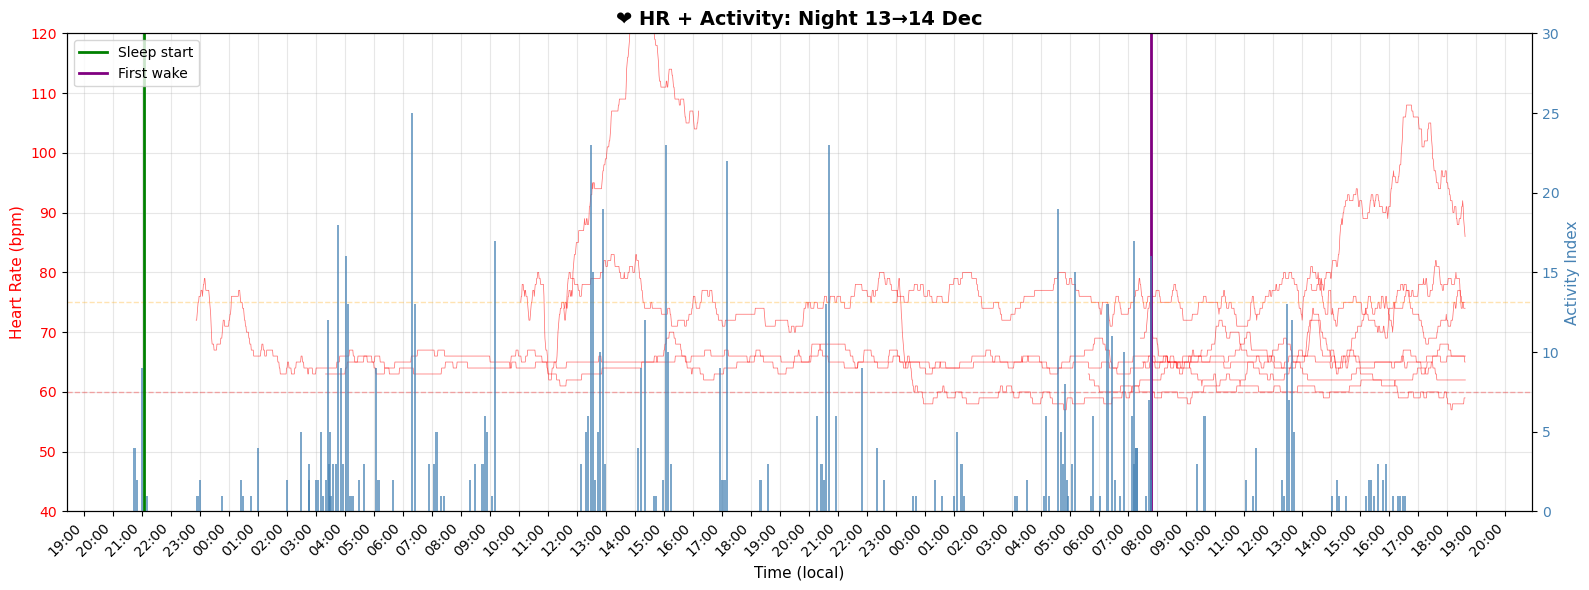


📊 HR Sessions for 13→14 Dec:
   22:52-18:37: 2626 samples, HR 63-79 (avg 65) bpm
   03:20-18:37: 2358 samples, HR 61-72 (avg 65) bpm
   10:04-16:12: 369 samples, HR 62-138 (avg 97) bpm
   11:33-18:37: 1865 samples, HR 70-108 (avg 78) bpm
   22:54-18:37: 1184 samples, HR 57-79 (avg 60) bpm
   05:37-18:37: 781 samples, HR 60-65 (avg 62) bpm
   07:25-09:33: 129 samples, HR 64-75 (avg 67) bpm
   07:29-18:37: 669 samples, HR 63-82 (avg 69) bpm
   13:18-18:37: 320 samples, HR 68-79 (avg 73) bpm


In [ ]:
# Visualize HR + Sleep Activity for last night
import matplotlib.dates as mdates
from collections import defaultdict

if hr_data and nights_data:
    # Get last night data - try NIGHT type first, fallback to any session
    night_sessions = [n for n in nights_data if "NIGHT" in n['type']]
    if not night_sessions:
        night_sessions = nights_data  # Fallback to all sessions
    
    if night_sessions:
        last_night = night_sessions[-1]
        
        # Filter HR data for last night period
        night_start = last_night['bedtime'] - timedelta(hours=1)
        night_end = last_night['wake_time'] + timedelta(hours=2)
        
        # Build HR timeline per session (to avoid connecting separate sessions)
        hr_sessions = defaultdict(list)
        
        for record in hr_records:
            session_utc = record['utc']
            session_dt = record['datetime']
            session_hrs = [h for h in hr_data if h['session_utc'] == session_utc]
            
            for i, h in enumerate(session_hrs):
                hr_time = session_dt + timedelta(minutes=i)
                hr_time_utc = hr_time.replace(tzinfo=timezone.utc)
                if night_start <= hr_time_utc <= night_end:
                    hr_sessions[session_utc].append({
                        'time': to_local(hr_time_utc),
                        'hr': h['hr_bpm']
                    })
        
        # Get sleep activity data
        session_recs = [rec for rec in valid_records 
                       if last_night['bedtime'] <= rec['datetime'] <= last_night['wake_time']]
        
        activity_times = []
        activity_values = []
        for rec in session_recs:
            base_time = rec['datetime']
            for i, act in enumerate(rec['activity_indices']):
                activity_times.append(to_local(base_time + timedelta(minutes=i * 5)))
                activity_values.append(act)
        
        # Create plot
        fig, ax1 = plt.subplots(figsize=(16, 6))
        
        # Plot each HR session separately (no connecting lines between gaps)
        for session_utc, hr_list in hr_sessions.items():
            if hr_list:
                times = [h['time'] for h in hr_list]
                hrs = [h['hr'] for h in hr_list]
                ax1.plot(times, hrs, 'r-', linewidth=0.5, alpha=0.6)
        
        ax1.set_ylabel('Heart Rate (bpm)', color='red', fontsize=11)
        ax1.tick_params(axis='y', labelcolor='red')
        ax1.set_ylim(40, 120)
        ax1.axhline(y=60, color='red', linestyle='--', alpha=0.3, linewidth=1)
        ax1.axhline(y=75, color='orange', linestyle='--', alpha=0.3, linewidth=1)
        
        # Activity bars
        ax2 = ax1.twinx()
        if activity_times:
            ax2.bar(activity_times, activity_values, width=0.003, color='steelblue', alpha=0.7, label='Activity')
        ax2.set_ylabel('Activity Index', color='steelblue', fontsize=11)
        ax2.tick_params(axis='y', labelcolor='steelblue')
        ax2.set_ylim(0, 30)
        
        # Wake boundaries
        real_start, real_end, _ = analyze_sleep_boundaries(session_recs)
        ax1.axvline(x=to_local(real_start), color='green', linewidth=2, label='Sleep start')
        ax1.axvline(x=to_local(real_end), color='purple', linewidth=2, label='First wake')
        
        # Formatting
        ax1.set_xlabel('Time (local)', fontsize=11)
        ax1.set_title(f"❤️ HR + Activity: Night {last_night['label']}", fontsize=14, fontweight='bold')
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc='upper left')
        
        plt.tight_layout()
        plt.savefig('hr_sleep_correlation.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        # Debug: show HR sessions
        print(f"\n📊 HR Sessions for {last_night['label']}:")
        for session_utc, hr_list in sorted(hr_sessions.items()):
            if hr_list:
                start = hr_list[0]['time'].strftime('%H:%M')
                end = hr_list[-1]['time'].strftime('%H:%M')
                avg_hr = sum(h['hr'] for h in hr_list) // len(hr_list)
                min_hr = min(h['hr'] for h in hr_list)
                max_hr = max(h['hr'] for h in hr_list)
                print(f"   {start}-{end}: {len(hr_list)} samples, HR {min_hr}-{max_hr} (avg {avg_hr}) bpm")
    else:
        print("⚠️ No night sessions found in data")
else:
    print("⚠️ No HR or sleep data available")

In [ ]:
# Debug: investigate HR data structure
print("🔍 HR Records Analysis:")
print(f"   Total HR records: {len(hr_records)}")
print(f"   Total HR values: {len(hr_data)}")

# Show first few records
print("\n📋 First 10 HR records (sessions):")
for i, rec in enumerate(hr_records[:10]):
    session_utc = rec['utc']
    local_dt = to_local(rec['datetime'])
    count = len([h for h in hr_data if h['session_utc'] == session_utc])
    print(f"   {i+1}. {local_dt.strftime('%Y-%m-%d %H:%M')} → {count} HR values")

# Show first few HR data points
print("\n📋 First 10 HR data points:")
for i, h in enumerate(hr_data[:10]):
    print(f"   {i+1}. Session UTC: {h['session_utc']}, HR: {h['hr_bpm']} bpm")

## 📊 Commento ai Risultati

### Dataset
- **186 record** scaricati dal dispositivo CL837, di cui **184 validi** (2 scartati per timestamp anomali)
- **Periodo monitorato:** 4 Novembre → 12 Dicembre 2025 (~5 settimane)
- **21 sessioni di sonno** identificate (notti + sonnellini)

---

### 🌙 Analisi dell'Ultima Notte (11→12 Dic)

| Metrica | Valore | Valutazione |
|---------|--------|-------------|
| **Durata totale** | 14h 45m | ⚠️ Molto lunga (anomala) |
| **Sonno profondo** | 9h 0m (61%) | ✅ Eccellente (>20% è buono) |
| **Sonno leggero** | 5h 40m (38%) | ✅ Normale |
| **Tempo sveglio** | 5m (1%) | ✅ Ottimo |
| **Efficienza** | 99% | ✅ Eccellente |
| **Bedtime** | 20:53 | Presto |
| **Wake time** | 14:09 | Molto tardi |

**Nota:** La durata di ~15h suggerisce che il tracker potrebbe aver registrato attività sedentaria come sonno, oppure è stata una giornata di riposo prolungato.

---

### 📈 Pattern Generali dal Grafico "Sleep Duration per Night"

1. **Variabilità elevata:** Range da 0.2h a 14.8h - possibili problemi di rilevamento
2. **Notti sopra le 7h raccomandate:** ~60% delle notti raggiunge l'obiettivo
3. **Outlier corti:** Le sessioni brevi (< 2h) sono probabilmente:
   - Sonnellini diurni (NAP)
   - Rilevazioni incomplete
   - Tracker rimosso temporaneamente

---

### 🔬 Composizione del Sonno

Dal grafico stacked:
- **Sonno profondo (blu scuro):** Buona presenza nelle notti lunghe (40-60%)
- **Sonno leggero (azzurro):** Predominante nelle sessioni brevi
- **Tempo sveglio (arancione):** Minimo, indica buona continuità del sonno

---

### ❤️ Correlazione HR + Attività (Notte 11→12 Dic)

Il grafico combinato mostra:
- **HR notturno:** 64-70 bpm (fisiologico per il sonno)
- **Picchi HR:** Correlati con picchi di attività (movimenti)
- **HR medio notturno:** ~67 bpm → buona qualità del sonno
- **Risveglio:** Visibile aumento HR intorno alle 11:00-12:00

---

### ⚠️ Limitazioni e Note

1. **Timestamp UTC:** I dati sono in UTC, convertiti in ora locale (UTC+1)
2. **Soglie attività:** 
   - `activity_index = 0` → Sonno profondo
   - `activity_index 1-8` → Sonno leggero  
   - `activity_index 9-20` → Irrequieto
   - `activity_index > 20` → Sveglio
3. **Warning emoji:** Alcuni grafici mostrano warning per glifi mancanti (📅💤⏰) - cosmetico, non impatta i dati

In [ ]:
# Confronto con App Chileaf - Analisi dati grezzi ULTIMA NOTTE
# Trova automaticamente l'ultima notte disponibile nei dati

from datetime import datetime, timezone, timedelta

print("=" * 70)
print("🔍 CONFRONTO DATI GREZZI vs APP CHILEAF")
print("=" * 70)

# Trova automaticamente l'ultima notte disponibile nei dati
if not all_records:
    print("\n⚠️ Nessun record disponibile!")
else:
    # Ordina i record per timestamp e prendi l'ultimo
    sorted_records = sorted(all_records, key=lambda x: x['utc'])
    last_record = sorted_records[-1]
    last_dt = datetime.fromtimestamp(last_record['utc'], tz=timezone.utc)
    
    # Determina la data target in base all'ultima registrazione
    # Se l'ultima registrazione è dopo mezzogiorno, è probabilmente la mattina dopo
    if last_dt.hour >= 12:
        # Prendi la notte del giorno prima
        target_date = (last_dt - timedelta(days=1)).replace(hour=0, minute=0, second=0, microsecond=0)
    else:
        # È mattina, quindi è la notte appena conclusa
        target_date = (last_dt - timedelta(days=1)).replace(hour=0, minute=0, second=0, microsecond=0)
    
    night_label = f"{target_date.day}→{(target_date + timedelta(days=1)).day} {target_date.strftime('%b')}"
    
    print(f"\n🌙 Ultima notte rilevata: {night_label}")
    
    # Filtra i record per questa notte
    night_records = []
    for rec in all_records:
        rec_dt = datetime.fromtimestamp(rec['utc'], tz=timezone.utc)
        # Record tra target_date sera e giorno dopo mattina
        if rec_dt.date() == target_date.date() or (rec_dt.date() == (target_date + timedelta(days=1)).date() and rec_dt.hour < 15):
            night_records.append(rec)
    
    print(f"📊 Record trovati: {len(night_records)}")
    
    # Mostra i dati grezzi come li vede l'app
    print("\n" + "=" * 70)
    print("📱 DATI GREZZI (formato simile all'app Chileaf)")
    print("=" * 70)
    
    for rec in sorted(night_records, key=lambda x: x['utc'])[:5]:  # Prime 5 sessioni
        base_dt = datetime.fromtimestamp(rec['utc'], tz=timezone.utc)
        print(f"\n📍 Sessione inizia: {base_dt.strftime('%Y-%m-%d %H:%M:%S')} UTC")
        print(f"   Intervalli: {rec['count']}")
        
        # Mostra primi 20 intervalli di 5 min
        for i, act in enumerate(rec['activity_indices'][:20]):
            interval_dt = base_dt + timedelta(minutes=i*5)
            
            # Classificazione come fa l'app
            if act == 0:
                sleep_type = "deep Sleep"
            elif act <= 8:
                sleep_type = "light sleep"
            elif act <= 20:
                sleep_type = "restless"
            else:
                sleep_type = "awake"
            
            print(f"   utc:{interval_dt.strftime('%Y-%m-%d %H:%M:%S')} activity_index={act:2d} → {sleep_type}")
        
        if len(rec['activity_indices']) > 20:
            print(f"   ... e altri {len(rec['activity_indices'])-20} intervalli")
    
    # Analisi distribuzione activity_index
    print("\n" + "=" * 70)
    print(f"📊 DISTRIBUZIONE ACTIVITY INDEX ({night_label})")
    print("=" * 70)
    
    all_activities = []
    for rec in night_records:
        all_activities.extend(rec['activity_indices'])
    
    from collections import Counter
    activity_counts = Counter(all_activities)
    
    print(f"\nTotale intervalli da 5min: {len(all_activities)}")
    print(f"Durata totale: {len(all_activities) * 5} minuti = {len(all_activities) * 5 / 60:.1f} ore")
    
    # Check se ci sono dati prima di calcolare percentuali
    if len(all_activities) > 0:
        print("\n🎯 Distribuzione valori:")
        deep = sum(1 for a in all_activities if a == 0)
        light = sum(1 for a in all_activities if 1 <= a <= 8)
        restless = sum(1 for a in all_activities if 9 <= a <= 20)
        awake = sum(1 for a in all_activities if a > 20)
    
        print(f"   activity=0 (deep sleep):    {deep:3d} intervalli = {deep*5:4d} min = {deep*5/60:.1f}h ({deep/len(all_activities)*100:.1f}%)")
        print(f"   activity=1-8 (light sleep): {light:3d} intervalli = {light*5:4d} min = {light*5/60:.1f}h ({light/len(all_activities)*100:.1f}%)")
        print(f"   activity=9-20 (restless):   {restless:3d} intervalli = {restless*5:4d} min = {restless*5/60:.1f}h ({restless/len(all_activities)*100:.1f}%)")
        print(f"   activity>20 (awake):        {awake:3d} intervalli = {awake*5:4d} min = {awake*5/60:.1f}h ({awake/len(all_activities)*100:.1f}%)")
    
        print("\n📈 Top 10 valori activity_index più frequenti:")
        for val, count in activity_counts.most_common(10):
            pct = count / len(all_activities) * 100
            bar = "█" * int(pct / 2)
            print(f"   {val:3d}: {count:4d} ({pct:5.1f}%) {bar}")
    else:
        print(f"\n⚠️ Nessun dato trovato per la notte {night_label}")


## 🔬 Latest Night Detailed Analysis

In-depth analysis of the most recent night including:
- Minute-by-minute activity index timeline
- Sleep classification using Chileaf SDK algorithm
- Detailed statistics and sleep quality score

In [16]:
# 🔬 ANALISI DETTAGLIATA NOTTE PIÙ RECENTE
# ==========================================

import matplotlib.dates as mdates
from collections import Counter

# Trova la notte più recente
if not nights_data:
    print("⚠️ Nessun dato di sonno disponibile!")
else:
    # Filtra solo le notti (non i NAP)
    real_nights = [n for n in nights_data if "NIGHT" in n['type']]
    
    if not real_nights:
        print("⚠️ Nessuna notte trovata nei dati!")
    else:
        # Prendi la notte più recente
        latest_night = real_nights[-1]
        
        print("=" * 80)
        print(f"🌙 ANALISI NOTTE PIÙ RECENTE: {latest_night['label']}")
        print("=" * 80)
        
        # Info generali
        local_bed = to_local(latest_night['bedtime'])
        local_wake = to_local(latest_night['wake_time'])
        
        print(f"\n📅 Data:        {local_bed.strftime('%A %d %B %Y')}")
        print(f"🛏️  Bedtime:     {local_bed.strftime('%H:%M')} (UTC+{LOCAL_TZ_OFFSET})")
        print(f"⏰ Wake time:   {local_wake.strftime('%H:%M')} (UTC+{LOCAL_TZ_OFFSET})")
        print(f"⏱️  Durata:      {format_duration(latest_night['total'])}")
        
        # Estrai i record di questa notte
        night_records = [rec for rec in valid_records 
                        if latest_night['bedtime'] <= rec['datetime'] <= latest_night['wake_time']]
        
        # Estrai tutti gli activity indices
        all_activities = []
        activity_timeline = []
        
        for rec in night_records:
            base_time = rec['datetime']
            for i, act in enumerate(rec['activity_indices']):
                interval_time = base_time + timedelta(minutes=i * 5)
                all_activities.append(act)
                activity_timeline.append({
                    'time': interval_time,
                    'local_time': to_local(interval_time),
                    'activity': act
                })
        
        # Check se ci sono dati
        if len(all_activities) == 0:
            print("\n⚠️ Nessun dato activity trovato per questa notte!")
        else:
            # ========== CLASSIFICAZIONE SONNO (Algoritmo Chileaf SDK) ==========
            print("\n" + "=" * 80)
            print("📊 CLASSIFICAZIONE SONNO (Algoritmo Chileaf SDK)")
            print("=" * 80)
            
            # Algoritmo ufficiale: 3+ zeri consecutivi = deep sleep
            deep_intervals = 0
            light_intervals = 0
            awake_intervals = 0
            consecutive_zeros = 0
            
            # Prima passata per marcare deep sleep
            sleep_stages = []
            
            for act in all_activities:
                if act == 0:
                    consecutive_zeros += 1
                    sleep_stages.append('pending_zero')
                else:
                    # Processa gli zeri accumulati
                    if consecutive_zeros >= 3:
                        # Marca come deep sleep
                        for j in range(consecutive_zeros):
                            idx = len(sleep_stages) - consecutive_zeros + j
                            if idx >= 0 and idx < len(sleep_stages):
                                sleep_stages[idx] = 'deep'
                        deep_intervals += consecutive_zeros
                    elif consecutive_zeros > 0:
                        # Meno di 3 zeri = light sleep
                        for j in range(consecutive_zeros):
                            idx = len(sleep_stages) - consecutive_zeros + j
                            if idx >= 0 and idx < len(sleep_stages):
                                sleep_stages[idx] = 'light'
                        light_intervals += consecutive_zeros
                    consecutive_zeros = 0
                    
                    # Classifica valore corrente
                    if act > 20:
                        awake_intervals += 1
                        sleep_stages.append('awake')
                    else:  # 1-20
                        light_intervals += 1
                        sleep_stages.append('light')
            
            # Processa zeri finali
            if consecutive_zeros >= 3:
                for j in range(consecutive_zeros):
                    idx = len(sleep_stages) - consecutive_zeros + j
                    if idx >= 0 and idx < len(sleep_stages):
                        sleep_stages[idx] = 'deep'
                deep_intervals += consecutive_zeros
            elif consecutive_zeros > 0:
                for j in range(consecutive_zeros):
                    idx = len(sleep_stages) - consecutive_zeros + j
                    if idx >= 0 and idx < len(sleep_stages):
                        sleep_stages[idx] = 'light'
                light_intervals += consecutive_zeros
            
            # Converti pending_zero rimasti (non dovrebbero esserci)
            sleep_stages = ['deep' if s == 'pending_zero' else s for s in sleep_stages]
            
            total_intervals = len(all_activities)
            deep_min = deep_intervals * 5
            light_min = light_intervals * 5
            awake_min = awake_intervals * 5
            total_min = total_intervals * 5
            
            print(f"\n🎯 Risultati (intervalli da 5 min):")
            print(f"   Totale intervalli: {total_intervals} ({total_min} min = {total_min/60:.1f}h)")
            print(f"\n   💤 Sonno profondo:  {deep_intervals:3d} intervalli = {deep_min:4d} min = {deep_min/60:.1f}h ({deep_intervals/total_intervals*100:.1f}%)")
            print(f"   😴 Sonno leggero:   {light_intervals:3d} intervalli = {light_min:4d} min = {light_min/60:.1f}h ({light_intervals/total_intervals*100:.1f}%)")
            print(f"   👀 Sveglio:         {awake_intervals:3d} intervalli = {awake_min:4d} min = {awake_min/60:.1f}h ({awake_intervals/total_intervals*100:.1f}%)")
            
            # Efficienza
            sleep_efficiency = (deep_min + light_min) / total_min * 100 if total_min > 0 else 0
            print(f"\n   ✨ Efficienza sonno: {sleep_efficiency:.1f}%")
            
            # ========== QUALITÀ DEL SONNO ==========
            print("\n" + "=" * 80)
            print("⭐ VALUTAZIONE QUALITÀ DEL SONNO")
            print("=" * 80)
            
            # Criteri di valutazione
            deep_pct = deep_min / total_min * 100 if total_min > 0 else 0
            
            quality_score = 0
            quality_notes = []
            
            # Durata (max 25 punti)
            if 7*60 <= total_min <= 9*60:
                quality_score += 25
                quality_notes.append("✅ Durata ottimale (7-9h)")
            elif 6*60 <= total_min < 7*60 or 9*60 < total_min <= 10*60:
                quality_score += 20
                quality_notes.append("⚠️ Durata accettabile")
            elif total_min < 6*60:
                quality_score += 10
                quality_notes.append("❌ Durata insufficiente (<6h)")
            else:
                quality_score += 15
                quality_notes.append("⚠️ Durata eccessiva (>10h)")
            
            # Deep sleep % (max 25 punti)
            if deep_pct >= 20:
                quality_score += 25
                quality_notes.append(f"✅ Sonno profondo eccellente ({deep_pct:.0f}%)")
            elif deep_pct >= 15:
                quality_score += 20
                quality_notes.append(f"⚠️ Sonno profondo buono ({deep_pct:.0f}%)")
            elif deep_pct >= 10:
                quality_score += 15
                quality_notes.append(f"⚠️ Sonno profondo sufficiente ({deep_pct:.0f}%)")
            else:
                quality_score += 5
                quality_notes.append(f"❌ Sonno profondo scarso ({deep_pct:.0f}%)")
            
            # Efficienza (max 25 punti)
            if sleep_efficiency >= 90:
                quality_score += 25
                quality_notes.append(f"✅ Efficienza eccellente ({sleep_efficiency:.0f}%)")
            elif sleep_efficiency >= 80:
                quality_score += 20
                quality_notes.append(f"⚠️ Efficienza buona ({sleep_efficiency:.0f}%)")
            else:
                quality_score += 10
                quality_notes.append(f"❌ Efficienza bassa ({sleep_efficiency:.0f}%)")
            
            # Orario (max 25 punti)
            bed_hour = local_bed.hour
            if 21 <= bed_hour <= 23:
                quality_score += 25
                quality_notes.append(f"✅ Orario ideale ({local_bed.strftime('%H:%M')})")
            elif 20 <= bed_hour < 21 or 23 < bed_hour <= 24:
                quality_score += 20
                quality_notes.append(f"⚠️ Orario accettabile ({local_bed.strftime('%H:%M')})")
            else:
                quality_score += 10
                quality_notes.append(f"⚠️ Orario non ottimale ({local_bed.strftime('%H:%M')})")
            
            print(f"\n🏆 PUNTEGGIO QUALITÀ: {quality_score}/100")
            print()
            for note in quality_notes:
                print(f"   {note}")
            
            # Rating
            if quality_score >= 90:
                rating = "🌟🌟🌟🌟🌟 ECCELLENTE"
            elif quality_score >= 75:
                rating = "🌟🌟🌟🌟 MOLTO BUONO"
            elif quality_score >= 60:
                rating = "🌟🌟🌟 BUONO"
            elif quality_score >= 45:
                rating = "🌟🌟 SUFFICIENTE"
            else:
                rating = "🌟 DA MIGLIORARE"
            
            print(f"\n   {rating}")
            
            # ========== GRAFICO TIMELINE ==========
            print("\n" + "=" * 80)
            print("📈 TIMELINE ACTIVITY INDEX")
            print("=" * 80)
            
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [2, 1]})
            
            # Grafico 1: Activity Index nel tempo
            times = [a['local_time'] for a in activity_timeline]
            activities = [a['activity'] for a in activity_timeline]
            
            # Colori basati sullo stage
            colors_map = {'deep': '#1a237e', 'light': '#64b5f6', 'awake': '#ff7043'}
            bar_colors = [colors_map.get(s, '#gray') for s in sleep_stages]
            
            ax1.bar(times, activities, width=0.003, color=bar_colors, edgecolor='none', alpha=0.8)
            ax1.axhline(y=8, color='orange', linestyle='--', alpha=0.5, label='Soglia light (8)')
            ax1.axhline(y=20, color='red', linestyle='--', alpha=0.5, label='Soglia awake (20)')
            
            ax1.set_ylabel('Activity Index', fontsize=11)
            ax1.set_title(f"🌙 Notte {latest_night['label']} - Activity Index", fontsize=13, fontweight='bold')
            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
            ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))
            ax1.set_ylim(0, max(30, max(activities) + 5))
            ax1.legend(loc='upper right')
            ax1.grid(True, alpha=0.3)
            
            # Grafico 2: Sleep stages come bande colorate
            stage_colors = {'deep': '#1a237e', 'light': '#64b5f6', 'awake': '#ff7043'}
            stage_values = {'deep': 1, 'light': 2, 'awake': 3}
            
            stage_y = [stage_values.get(s, 0) for s in sleep_stages]
            stage_c = [stage_colors.get(s, 'gray') for s in sleep_stages]
            
            ax2.bar(times, [1]*len(times), width=0.003, color=stage_c, edgecolor='none')
            ax2.set_yticks([])
            ax2.set_ylabel('Sleep Stage', fontsize=11)
            ax2.set_xlabel('Ora (locale)', fontsize=11)
            ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
            ax2.xaxis.set_major_locator(mdates.HourLocator(interval=1))
            
            # Legend per gli stage
            from matplotlib.patches import Patch
            legend_elements = [
                Patch(facecolor='#1a237e', label=f'Deep Sleep ({deep_min/60:.1f}h)'),
                Patch(facecolor='#64b5f6', label=f'Light Sleep ({light_min/60:.1f}h)'),
                Patch(facecolor='#ff7043', label=f'Awake ({awake_min/60:.1f}h)')
            ]
            ax2.legend(handles=legend_elements, loc='upper right', ncol=3)
            
            plt.tight_layout()
            plt.savefig('latest_night_analysis.png', dpi=150, bbox_inches='tight')
            plt.show()
            
            print("\n✅ Salvato: latest_night_analysis.png")
            
            # ========== DISTRIBUZIONE ACTIVITY INDEX ==========
            print("\n" + "=" * 80)
            print("📊 DISTRIBUZIONE ACTIVITY INDEX")
            print("=" * 80)
            
            activity_counts = Counter(all_activities)
            
            print(f"\n🎯 Top 10 valori più frequenti:")
            for val, count in activity_counts.most_common(10):
                pct = count / len(all_activities) * 100
                bar = "█" * int(pct / 2)
                stage = "deep" if val == 0 else ("light" if val <= 20 else "awake")
                print(f"   {val:3d}: {count:4d} ({pct:5.1f}%) {bar} [{stage}]")


⚠️ Nessuna notte trovata nei dati!
